# Barcelona Airbnb 2021


## Section 1: Business Understanding

This project intends to evaluate the effect of the Covid19 pandemic on [Airbnb hosting prices](http://insideairbnb.com/get-the-data.html) in the city of Barcelona. We use the number of reviews as a metric for the number of tourists in the city and the number of positive cases for the prevalence of [Covid19](https://cnecovid.isciii.es/covid19/#documentaci%C3%B3n-y-datos) in the region of Catalonia.



### Question 1: How was tourism affected by the Covid19 outbreak during the last months?
### Question 2: How did the price evolved for both visited and non-visited listings?
### Question 3: Which are the key success factors to attract guests?


Sources: [Inside Airbnb](http://insideairbnb.com/get-the-data.html), [Covid19](https://cnecovid.isciii.es/covid19/#documentaci%C3%B3n-y-datos)


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

#Fetching data. From the Airbnb source, we create a dataset dictionary with an entry for each month

lsts = {'aug': pd.read_csv('./listings_aug20.csv'),
        'sept': pd.read_csv('./listings_sept20.csv'),
        'oct': pd.read_csv('./listings_oct20.csv'),
        'nov': pd.read_csv('./listings_nov20.csv'),
        'dec': pd.read_csv('./listings_dec20.csv'),
        'jan': pd.read_csv('./listings_jan21.csv'),
        'feb': pd.read_csv('./listings_feb21.csv'),
        'mar': pd.read_csv('./listings_mar21.csv'),
        'apr': pd.read_csv('./listings_apr21.csv')      
      }


In /home/jorge/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jorge/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jorge/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/jorge/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jorge/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

## Data Exploration

For the data exploration, only one dataset will be used since all of them share the same columns and have similar number of listings. Therefore, all of them will be processed equally

In [81]:
# Columns of the datasets
lsts['sept'].columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

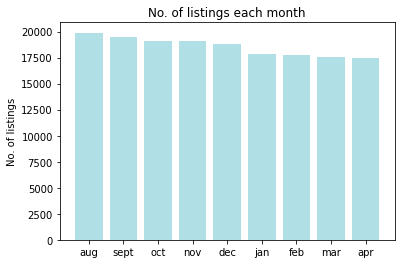

In [78]:
# Size of each dataset
n_listings = [lsts[month].shape[0] for month in lsts]
plt.bar(lsts.keys(), n_listings, color='powderblue')
plt.ylabel('No. of listings')
plt.title('No. of listings each month')

plt.savefig('q22.png', dpi=300)

## Preprocessing Data

In [19]:
# We set the identifier as the index for every dataframe
for month in lsts:
    lsts[month].set_index('id', inplace = True)

In [20]:
# Some listings have more beds than people that they can accommodate. 
# This might be due to hosts who did not filled the information properly
sum(lsts['sept']['beds']-lsts['sept']['accommodates']>0)

447

In [21]:
# To solve the bed/accomm paradox, the number of occupants is the maximum of both
for key in lsts.keys():
    lsts[key]['capacity'] = lsts[key].apply(lambda x: max(x['beds'], x['accommodates']), axis = 1)

In [22]:
# Column 'price' is string type, whose format is '$1,000.00'. We store the int value in 'price_numeric'
# We also are interested in the price per guest, as it might be more relevant
for key in lsts.keys():
    lsts[key]['price_numeric'] = lsts[key].apply(lambda x: int(x['price'][1:-3].replace(',','')),                                                  axis = 1)
    lsts[key]['price_person'] = lsts[key].apply(lambda x: x['price_numeric']/x['capacity'],                                                           axis = 1)

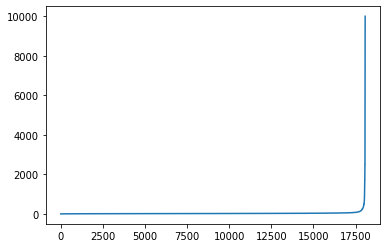

In [23]:
# The price distribution shows a massive variance. A small percentage of listings have an extremely high price compared to the others
prices_feb = lsts['feb']['price_person'].sort_values().copy()
prices_feb = prices_feb.reset_index()['price_person']
plt.plot(prices_feb)

In [24]:
# To avoid misleading results, these listings will be trimmed. Only the 98 percentile will remain
for key in lsts:
    cutoff = lsts[key]['price_person'].quantile(q=0.98)
    lsts[key] = lsts[key][lsts[key]['price_person']<cutoff]

In [25]:
mean_price = [lsts[key]['price_person'].mean() for key in lsts.keys()]
mean_occu = [lsts[key]['number_of_reviews_l30d'].mean() for key in lsts.keys()]

## Data Cleansing for modeling

In [26]:
# We create a blank dataframe which will be filled with some columns from the original dataframe
df = pd.DataFrame()

In [27]:
# Our target variable for the model is a boolean variable with value 1 if the listing had any review during the last month and 0 if not
df['had_reviews']=lsts['aug']['number_of_reviews_l30d'].apply(lambda x: 0 if x==0 else 1)

# Filter numerical features from the DataFrame
numerical_columns = lsts['aug'].columns[(lsts['aug'].dtypes==int)|(lsts['aug'].dtypes==float)]
# Drop target feature
numerical_columns = numerical_columns.drop(['number_of_reviews_l30d'])
# Drop potential leaking values
numerical_columns = numerical_columns.drop(['availability_30','availability_60','availability_90','availability_365'])
# Drop non-relevant features
numerical_columns = numerical_columns.drop(['scrape_id', 'host_id'])
# Insert into the new DataFrame
df[numerical_columns] = lsts['aug'][numerical_columns]

In [28]:
numerical_columns

Index(['host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'number_of_reviews',
       'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'capacity', 'price_numeric', 'price_person'],
      dtype='object')

In [107]:
lsts['aug'].columns[lsts['aug'].dtypes==object]

Index(['listing_url', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'bathrooms_text', 'amenities', 'price', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review', 'license',
       'instant_bookable'],
      dtype='object')

In [29]:
# let's save only those columns that might be useful
bool_columns = ['host_is_superhost',
                'host_has_profile_pic',
                'host_identity_verified',
                'has_availability',
                'instant_bookable']

# and change its value to binary
df[bool_columns]=lsts['aug'][bool_columns].replace({'t': 1, 'f': 0})

In [30]:
# Some variables need to be ordinally encoded
df['host_acceptance_rate'] = lsts['aug']['host_acceptance_rate'].dropna().apply(lambda x: int(x[:-1]))
tiers = {'within an hour': 1, 'within a few hours': 2, 
 'within a day': 3, 'a few days or more': 4}
df['host_response_time']=lsts['aug']['host_response_time'].replace(tiers)

In [31]:
# We transform temporal variables into int type
date_columns = ['last_scraped',
                'host_since',
                'calendar_last_scraped',
                'first_review']
df[date_columns] = lsts['aug'][date_columns].dropna().applymap(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').toordinal())

In [32]:
# Some variables need to be one-hot encoded
neig_columns = ['neighbourhood_cleansed','neighbourhood_group_cleansed']
dummies = pd.get_dummies(lsts['aug'][neig_columns], dummy_na=True)
df[dummies.columns] = dummies

<AxesSubplot:ylabel='id'>

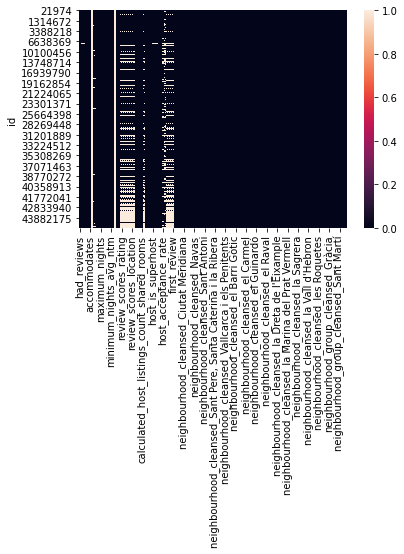

In [33]:
sns.heatmap(df.isna())

In [34]:
#both 'calendar_updates' and 'bathrooms' features are NaN
df.dropna(axis=1, how='all', inplace=True)
df.dropna(axis=0, how='all', inplace=True)

In [35]:
# we also remove any column with more than a 78% of missing values
df.dropna(how='all', thresh = 0.78*df.shape[1], inplace=True)

In [36]:
# Some values of number of beds are missing
# We calculate the ratio beds/bedroom, and use it for approximating the number of bedrooms 
ratio_beds_bedrooms = (df['beds']/df['bedrooms']).mean()
df.loc[df['bedrooms'].isna(), 'bedrooms'] = df['beds'][df['bedrooms'].isna()]/ratio_beds_bedrooms 


In [37]:
# For the rest of the values, we simply substitute it with the mode
na_columns = df.columns[df.isna().sum()>0]
for column in na_columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [38]:
df.columns[df.isna().sum()>0] # check that there isn't any NaN

Index([], dtype='object')

## Model training


In [39]:
X = df.drop(columns=['had_reviews'])
y = df['had_reviews']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [40]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

In [121]:
metrics.confusion_matrix(y_test, y_pred)

array([[4364,   37],
       [ 300,  169]])

# Question 1: How was tourism affected by the Covid19 outbreak during the last months?

The daily record of Covid19 infections in every region of Spain can be found [here](https://cnecovid.isciii.es/covid19/#documentaci%C3%B3n-y-datos).

In [42]:
# Dates when each dataset was created
dates = {'aug': datetime.datetime(2020,8,24),
         'sept': datetime.datetime(2020,9,12),
         'oct': datetime.datetime(2020,10,12),
         'nov': datetime.datetime(2020,11,6),
         'dec': datetime.datetime(2020,12,16),
         'jan': datetime.datetime(2021,1,12),
         'feb': datetime.datetime(2021,2,9),
         'mar': datetime.datetime(2021,3,5),
         'apr': datetime.datetime(2021,4,12)
         }
date_series = pd.Series(data=dates)

In [43]:
cases_total = pd.read_csv('casos_tecnica_ccaa.csv') #covid cases in Spain
cases_total.set_index('ccaa_iso', inplace = True)
cases_cat = cases_total.loc['CT',['fecha','num_casos']] #covid cases in Catalonia
cases_cat['fecha'] = [datetime.datetime.strptime(date,"%Y-%m-%d" ) for date in cases_cat['fecha']]
cases_cat = cases_cat[(cases_cat['fecha']>=dates['aug']-datetime.timedelta(30))&(cases_cat['fecha']<=dates['apr'])] 

In [44]:
# List with the mean number of reviews of each month
mean_num_reviews = [lsts[key]['number_of_reviews_l30d'].mean() for key in lsts]

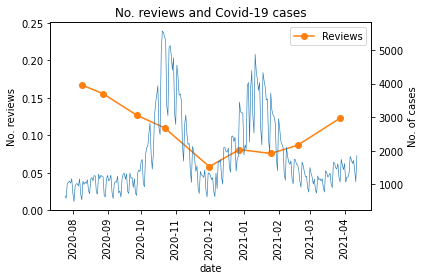

In [45]:
y = mean_num_reviews
fig, ax1 = plt.subplots()
ax1.plot_date(date_series-datetime.timedelta(15), y, 
              xdate=True, ls='-', color = 'tab:orange',
              label = 'Reviews')
ax1.set_xlabel('date')
ax1.set_ylabel('No. reviews')
ax1.set_title('No. reviews and Covid-19 cases')
ax1.xaxis.set_tick_params(rotation = 90) 
ax1.set_ylim(ymin=0, ymax=1.5*np.nanmax(y))

ax2 = ax1.twinx()
ax2.plot_date(cases_cat['fecha'], cases_cat['num_casos'], '-',
              xdate=True, linewidth=0.6, label='Covid' )
ax2.set_ylabel('No. of cases')
ax1.legend()


plt.tight_layout()
plt.savefig('q1.png', dpi=300)

# Question 2: How did the price evolved for both visited and non-visited listings?

In [46]:
visited_price = []
empty_price = []
for key in lsts:
    visited_price.append(lsts[key].loc[lsts[key]['number_of_reviews_l30d']>0,'price_person'].mean())
    empty_price.append(lsts[key].loc[lsts[key]['number_of_reviews_l30d']==0,'price_person'].mean())

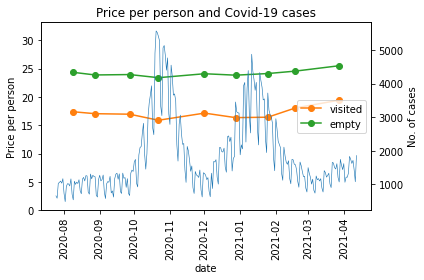

In [79]:
y = visited_price
fig, ax1 = plt.subplots()
ax1.plot_date(date_series-datetime.timedelta(15), visited_price, 
              xdate=True, ls='-', color = 'tab:orange',
              label = 'visited')
ax1.plot_date(date_series-datetime.timedelta(15), empty_price, 
              xdate=True, ls='-', color = 'tab:green',
              label = 'empty')
ax1.set_xlabel('date')
ax1.set_ylabel('Price per person')
ax1.set_title('Price per person and Covid-19 cases')
ax1.xaxis.set_tick_params(rotation = 90) 
ax1.set_ylim(ymin=0, ymax=1.3*np.nanmax(empty_price))

ax2 = ax1.twinx()
ax2.plot_date(cases_cat['fecha'], cases_cat['num_casos'], '-',
              xdate=True, linewidth=0.6, label='Covid' )
ax2.set_ylabel('No. of cases')
ax1.legend(loc=7)


plt.tight_layout()
plt.savefig('q2.png', dpi=300)


# Question 3: Which are the key success factors to attract guests?

In [48]:
df_comparison = df.groupby('had_reviews').mean()
df_comparison.index.name = None
df_comparison = df_comparison.T
df_comparison['Relative difference'] = df_comparison.apply(lambda x: 100*(x[1]-x[0])/((x[0]+x[1])/2), axis = 1) 

In [52]:
df_comparison

,0,1,Relative difference
host_listings_count,17.484416,15.034324,-15.068802
host_total_listings_count,17.484416,15.034324,-15.068802
latitude,41.392204,41.390631,-0.003800
longitude,2.167103,2.169087,0.091497
accommodates,3.302481,3.707480,11.554939
...,...,...,...
neighbourhood_group_cleansed_Sant Andreu,0.017340,0.006660,-89.003805
neighbourhood_group_cleansed_Sant Martí,0.100976,0.101947,0.956992
neighbourhood_group_cleansed_Sants-Montjuïc,0.116532,0.093238,-22.209332
neighbourhood_group_cleansed_Sarrià-Sant Gervasi,0.042710,0.023053,-59.779777


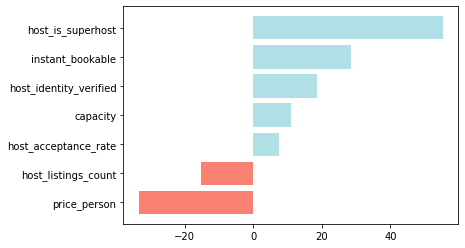

In [57]:
features = ['price_person', 'capacity', 'host_listings_count', 
            'host_is_superhost','host_acceptance_rate', 'instant_bookable', 'host_identity_verified']
plot_df = df_comparison.loc[features]
plot_df.sort_values(by='Relative difference', inplace=True)
colors = plot_df['Relative difference'].apply(lambda x: 'powderblue' if x>=0 else 'salmon')
plt.barh(plot_df.index, width=plot_df['Relative difference'], color=colors)
plt.savefig('q3.png', dpi=400, bbox_inches='tight')